In [1]:
## Load libraries
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
plt.style.use('dark_background')
%matplotlib inline

In [2]:
np.set_printoptions(precision=2)

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.15.0'

---

Mount Google Drive if running in Colab

---

In [ ]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/EvenSem2024MAHE'
    DATA_DIR = DIR + '/Data/'
    os.chdir(DIR)
else:
    DATA_DIR = 'Data/'

---

Load diabetes data

---

In [5]:
## Load Bengaluru house price data
file = 'diabetes_regression.csv'
df= pd.read_csv(file, header = 0)

print('Diabetes dataset')
print('-----------')
print('Initial number of samples = %d'%(df.shape[0]))
print('Initial number of features = %d\n'%(df.shape[1]))
df.head(5)

Diabetes dataset
-----------
Initial number of samples = 442
Initial number of features = 11



,AGE,GENDER,BMILEVEL,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,unhealthy,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,healthy,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,unhealthy,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,overweight,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,healthy,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [7]:
## Create lists of ordinal, categorical, and continuous features
categorical_features = (['BMILEVEL', 'GENDER'])
continuous_features = df.drop(categorical_features, axis = 1).columns.tolist()
print(categorical_features)
print(continuous_features)

['BMILEVEL', 'GENDER']
['AGE', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'Y']


---

Assign 'category' datatype to categorical columns

---

In [8]:
## Assign 'category' datatype to ordinal and categorical columns
print(df.dtypes)
df[categorical_features] = df[categorical_features].astype('category')
print('----')
df.dtypes

AGE           int64
GENDER        int64
BMILEVEL     object
BP          float64
S1            int64
S2          float64
S3          float64
S4          float64
S5          float64
S6            int64
Y             int64
dtype: object
----


AGE            int64
GENDER      category
BMILEVEL    category
BP           float64
S1             int64
S2           float64
S3           float64
S4           float64
S5           float64
S6             int64
Y              int64
dtype: object

---

Remove the target variable column from the list of continuous features

---

In [9]:
## Remove the target variable column from the list of continuous features
continuous_features.remove('Y')

In [10]:
## Train and test split of the data
X = df.drop('Y', axis = 1)
y = df['Y']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

num_features = X_train.shape[0]
num_samples = X_train.shape[1]

print('Diabetes data set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))

Diabetes data set
---------------------
Number of training samples = 10
Number of features = 353


---

Build pipeline for categorical and continuous features

---

In [11]:
## Build pipeline for categorical and continuous features

# Pipeline object for categorical (features
categorical_transformer = Pipeline(steps = [('onehotenc', OneHotEncoder(handle_unknown = 'ignore'))])

# Pipeline object for continuous features
continuous_transformer = Pipeline(steps = [('scaler', StandardScaler())])

# Create a preprocessor object for all features
preprocessor = ColumnTransformer(transformers = [('continuous',continuous_transformer, continuous_features),
                                                 ('categorical', categorical_transformer, categorical_features)
                                                ],
                                 remainder = 'passthrough'
                                 )

---

Fit and transform train data using preprocessor followed by transforming test data

---

In [12]:
## Fit and transform train data using preprocessor
X_train_transformed = preprocessor.fit_transform(X_train).T

# Update number of features
num_features = X_train_transformed.shape[0]
# Transform training data using preprocessor
X_test_transformed = preprocessor.transform(X_test).T
# Convert Y_train and Y_test to numpy arrays
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

---

A generic layer class with forward and backward methods

----

In [13]:
class Layer:
  def __init__(self):
    self.input = None
    self.output = None

  def forward(self, input):
    pass

  def backward(self, output_gradient, learning_rate):
    pass

---

Mean squared error (MSE) loss and its gradient

---

In [14]:
## Define the loss function and its gradient
def mse(Y, Yhat):
  return(np.mean((Y - Yhat)**2))
  #TensorFlow in-built function for mean squared error loss
  #mse = tf.keras.losses.MeanSquaredError()
  #mse(Y, Yhat).numpy()

def mse_gradient(Y, Yhat):
  return(Yhat - Y)

---

Generic activation layer class

---

In [15]:
class Activation(Layer):
    def __init__(self, activation, activation_gradient):
        self.activation = activation
        self.activation_gradient = activation_gradient

    def forward(self, input):
        self.input = input
        self.output = self.activation(self.input)
        return(self.output)

    def backward(self, output_gradient, learning_rate = None):
        return(output_gradient[:-1, :] * self.activation_gradient(self.input))

---

Specific activation layer classes

---

In [16]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(z):
            return 1 / (1 + np.exp(-z))

        def sigmoid_gradient(z):
            a = sigmoid(z)
            return a * (1 - a)

        super().__init__(sigmoid, sigmoid_gradient)

class Tanh(Activation):
    def __init__(self):
        def tanh(z):
            return np.tanh(z)

        def tanh_gradient(z):
            a = np.tanh(z)
            return 1 - a**2

        super().__init__(tanh, tanh_gradient)

class ReLU(Activation):
    def __init__(self):
        def relu(z):
            return z * (z > 0)

        def relu_gradient(z):
            return 1. * (z > 0)

        super().__init__(relu, relu_gradient)

---

Dense layer class

---

In [17]:
## Dense layer class
class Dense(Layer):
    def __init__(self, input_size, output_size, reg_strength):
        self.weights = 0.01*np.random.randn(output_size, input_size+1) # bias trick
        self.weights[:, -1] = 0.01 # set all bias values to the same nonzero constant
        self.reg_strength = reg_strength
        self.reg_loss = None

    def forward(self, input):
        self.input = np.vstack([input, np.ones((1, input.shape[1]))]) # bias trick
        self.output= np.dot(self.weights, self.input)
        # Calculate regularization loss
        self.reg_loss = self.reg_strength * np.sum(self.weights[:, :-1] * self.weights[:, :-1])

    def backward(self, output_gradient, learning_rate):
        ## Following is the inefficient way of calculating the backward gradient
        #weights_gradient = np.zeros((self.output.shape[0], self.input.shape[0]), dtype = np.float64)
        #for b in range(output_gradient.shape[1]):
        #  weights_gradient += np.dot(output_gradient[:, b].reshape(-1, 1), self.input[:, b].reshape(-1, 1).T)
        #weights_gradient = (1/output_gradient.shape[1])*weights_gradient

        ## Following is the efficient way of calculating the weights gradient w.r.t. data
        weights_gradient = (1/output_gradient.shape[1])*np.dot(np.atleast_2d(output_gradient), np.atleast_2d(self.input).T)
        # Add the regularization gradient here
        weights_gradient += 2 * self.reg_strength * np.hstack([self.weights[:, :-1], np.zeros((self.weights.shape[0], 1))])


        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights = self.weights + learning_rate * (-weights_gradient)

        return(input_gradient)

---

Function to generate sample indices for batch processing according to batch size

---

In [18]:
## Function to generate sample indices for batch processing according to batch size
def generate_batch_indices(num_samples, batch_size):
  # Reorder sample indices
  reordered_sample_indices = np.random.choice(num_samples, num_samples, replace = False)
  # Generate batch indices for batch processing
  batch_indices = np.split(reordered_sample_indices, np.arange(batch_size, len(reordered_sample_indices), batch_size))
  return(batch_indices)

---

Train the 1-hidden layer neural network (128 nodes) using batch training with batch size = 16

---

In [26]:
## Train the 2-hidden layer neural network (8 nodes, 8 nodes followed by 1 node)
## using batch training with batch size = 100
learning_rate = 1e-03 # learning rate
batch_size = 16 # batch size
nepochs = 10000 # number of epochs
reg_strength = 0.01 # regularization strength
# Create empty array to store training losses over each epoch
loss_train_epoch = np.empty(nepochs, dtype = np.float64)
# Create empty array to store test losses over each epoch
loss_test_epoch = np.empty(nepochs, dtype = np.float64)


# Neural network architecture

dlayer1 = Dense(num_features, 8, reg_strength) # define dense layer 1
alayer1 = ReLU() # ReLU activation layer 1
dlayer2 = Dense(8, 1, reg_strength) # define dense layer 2

# Steps: run over each sample in the batch, calculate loss, gradient of loss,
# and update weights.

epoch = 0
while epoch < nepochs:
  batch_indices = generate_batch_indices(num_samples, batch_size)
  loss = 0
  for b in range(len(batch_indices)):
    # Forward propagation for training data
    dlayer1.forward(X_train_transformed[:, batch_indices[b]]) # forward prop dense layer 1 with batch feature added
    alayer1.forward(dlayer1.output) # forward prop activation layer 1
    dlayer2.forward(alayer1.output) # forward prop dense layer 2
    # Calculate training data loss
    loss += mse(Y_train[batch_indices[b]], dlayer2.output)
    # Add the regularization losses
    loss += dlayer1.reg_loss + dlayer2.reg_loss

    # Backward prop starts here
    grad = mse_gradient(Y_train[batch_indices[b]], dlayer2.output)
    grad = dlayer2.backward(grad, learning_rate)
    grad = alayer1.backward(grad)
    grad = dlayer1.backward(grad, learning_rate)
  # Calculate the average training loss for the current epoch
  loss_train_epoch[epoch] = loss/len(batch_indices)

  # Forward propagation for test data
  dlayer1.forward(X_test_transformed)
  alayer1.forward(dlayer1.output)
  dlayer2.forward(alayer1.output)

  # Calculate test data loss plus regularization loss
  loss_test_epoch[epoch] =  mse(Y_test,dlayer2.output) + dlayer1.reg_loss + dlayer2.reg_loss

  print('Epoch %d: train loss = %f, test loss = %f'%(epoch+1, loss_train_epoch[epoch], loss_test_epoch[epoch]))
  epoch = epoch + 1

Epoch 1: train loss = 25006.592098, test loss = 26951.593589
Epoch 2: train loss = 24963.896749, test loss = 26908.592798
Epoch 3: train loss = 24921.284867, test loss = 26865.654206
Epoch 4: train loss = 24878.724171, test loss = 26822.745696
Epoch 5: train loss = 24836.168405, test loss = 26779.834900
Epoch 6: train loss = 24793.579059, test loss = 26736.870399
Epoch 7: train loss = 24750.876388, test loss = 26693.774422
Epoch 8: train loss = 24707.950703, test loss = 26650.442419
Epoch 9: train loss = 24664.658532, test loss = 26606.724132
Epoch 10: train loss = 24620.793232, test loss = 26562.380615
Epoch 11: train loss = 24576.027963, test loss = 26517.084479
Epoch 12: train loss = 24529.902410, test loss = 26470.340589
Epoch 13: train loss = 24481.729431, test loss = 26421.419360
Epoch 14: train loss = 24430.497108, test loss = 26369.258154
Epoch 15: train loss = 24374.716351, test loss = 26312.281289
Epoch 16: train loss = 24312.198582, test loss = 26248.190689
Epoch 17: train l

---

Plot training loss vs. epoch

---

Text(0.5, 1.0, 'Loss vs. Epoch for reg. strength 0.01')

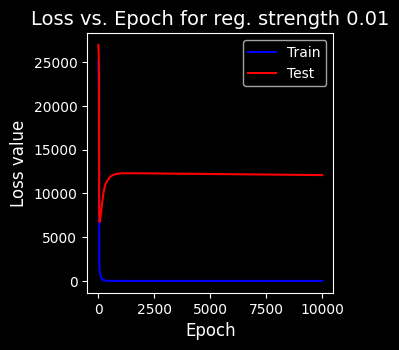

In [27]:
# Plot train and test loss as a function of epoch:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
fig.tight_layout(pad = 4.0)
ax.plot(loss_train_epoch, 'b', label = 'Train')
ax.plot(loss_test_epoch, 'r', label = 'Test')
ax.set_xlabel('Epoch', fontsize = 12)
ax.set_ylabel('Loss value', fontsize = 12)
ax.legend()
ax.set_title('Loss vs. Epoch for reg. strength 0.01', fontsize = 14)

---

Test performance on test data

---

In [28]:
dlayer1.forward(X_test_transformed)
alayer1.forward(dlayer1.output)
dlayer2.forward(alayer1.output)
ypred = dlayer2.output.flatten()
ytrue = Y_test
np.column_stack((ytrue, ypred))

array([[ 78.  ,  13.25],
       [152.  ,  71.77],
       [200.  , 357.32],
       [ 59.  ,  55.69],
       [311.  , 223.85],
       [178.  , 179.17],
       [332.  , 244.3 ],
       [132.  ,  33.72],
       [156.  ,  53.48],
       [135.  , 127.89],
       [220.  , 354.81],
       [233.  , 321.54],
       [ 91.  ,  14.01],
       [ 51.  ,  19.72],
       [195.  , 325.9 ],
       [109.  , 340.44],
       [217.  , 127.  ],
       [ 94.  ,  59.07],
       [ 89.  , 151.58],
       [111.  , 228.39],
       [129.  , 275.9 ],
       [181.  ,  73.46],
       [168.  , 285.51],
       [ 97.  ,  72.02],
       [115.  ,  72.11],
       [202.  , 207.53],
       [ 84.  ,  53.89],
       [147.  , 263.06],
       [253.  , 171.51],
       [144.  , 216.85],
       [262.  , 262.94],
       [115.  , 211.76],
       [ 68.  , 288.13],
       [ 65.  ,  49.47],
       [252.  , 152.7 ],
       [212.  , 261.28],
       [142.  , 145.07],
       [215.  , 365.87],
       [180.  , 236.33],
       [163.  , 246.35],
